In [49]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob


In [50]:
IMG_SIZE = 128
BATCH_SIZE = 4

In [51]:
class SegmentationGenerator(tf.keras.utils.Sequence):

    def __init__(self, image_path, mask_path, batch_size=4):
        self.image_paths = sorted(glob(os.path.join(image_path, "*")))
        self.mask_paths = sorted(glob(os.path.join(mask_path, "*")))
        self.batch_size = batch_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        batch_images = self.image_paths[index*self.batch_size:(index+1)*self.batch_size]
        batch_masks = self.mask_paths[index*self.batch_size:(index+1)*self.batch_size]

        images = []
        masks = []

        for img_path, mask_path in zip(batch_images, batch_masks):

            # ---- IMAGE ----
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype(np.float32) / 255.0

            # ---- MASK (CORRECT WAY) ----
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            mask = cv2.resize(
                mask,
                (IMG_SIZE, IMG_SIZE),
                interpolation=cv2.INTER_NEAREST   # IMPORTANT
            )

            # Convert to binary
            mask = (mask > 127).astype(np.float32)

            mask = np.expand_dims(mask, axis=-1)

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)


In [52]:
train_gen = SegmentationGenerator(
    r"F:\work\python\archive\segmentation_task\train\images",
    r"F:\work\python\archive\segmentation_task\train\masks",
    batch_size=BATCH_SIZE
)

val_gen = SegmentationGenerator(
    r"F:\work\python\archive\segmentation_task\test\images",
    r"F:\work\python\archive\segmentation_task\test\masks",
    batch_size=BATCH_SIZE
)


Unique mask values: [0. 1.]


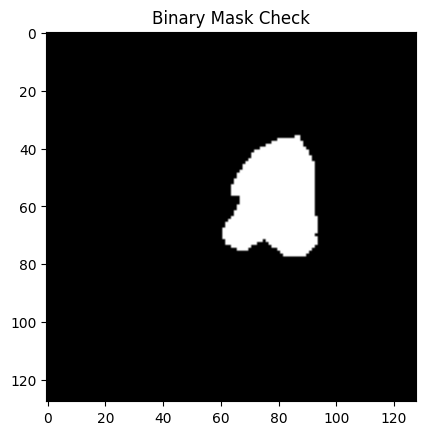

In [53]:
sample_images, sample_masks = train_gen[0]
print("Unique mask values:", np.unique(sample_masks[0]))

plt.imshow(sample_masks[0].squeeze(), cmap="gray")
plt.title("Binary Mask Check")
plt.show()


In [59]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / \
           (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

In [60]:
from tensorflow.keras import layers, Model

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

def build_unet(input_shape=(128,128,3)):

    inputs = layers.Input(input_shape)

    # Encoder
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D()(c3)

    c4 = conv_block(p3, 256)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    c5 = conv_block(p4, 512)

    # Decoder
    u6 = layers.UpSampling2D()(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = conv_block(u6, 256)

    u7 = layers.UpSampling2D()(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = conv_block(u7, 128)

    u8 = layers.UpSampling2D()(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = conv_block(u8, 64)

    u9 = layers.UpSampling2D()(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = conv_block(u9, 32)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c9)

    model = Model(inputs, outputs)
    return model


In [61]:
model = build_unet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=bce_dice_loss,
    metrics=[dice_coef, iou]
)

In [62]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

Epoch 1/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 248s 250ms/step - dice_coef: 0.2824 - iou: 0.1899 - loss: 0.8128 - val_dice_coef: 0.5035 - val_iou: 0.3638 - val_loss: 0.5968
Epoch 2/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 260s 265ms/step - dice_coef: 0.5845 - iou: 0.4549 - loss: 0.4722 - val_dice_coef: 0.6344 - val_iou: 0.5030 - val_loss: 0.4360
Epoch 3/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 287s 292ms/step - dice_coef: 0.6570 - iou: 0.5373 - loss: 0.3890 - val_dice_coef: 0.7027 - val_iou: 0.5829 - val_loss: 0.3478
Epoch 4/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 297s 302ms/step - dice_coef: 0.6986 - iou: 0.5798 - loss: 0.3416 - val_dice_coef: 0.7192 - val_iou: 0.6001 - val_loss: 0.3205
Epoch 5/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 367s 373ms/step - dice_coef: 0.7220 - iou: 0.6048 - loss: 0.3162 - val_dice_coef: 0.7494 - val_iou: 0.6333 - val_loss: 0.2877
Epoch 6/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 299s 304ms/step - dice_coef: 0.7541 - iou: 0.6409 - loss: 0.2784 - val_dice_coef: 0.7562 - val_iou: 0.6422 - val_loss: 0.2781
Epoc

In [63]:
results = model.evaluate(val_gen)

print("Test Loss:", results[0])
print("Dice Score:", results[1])
print("IoU Score:", results[2])


215/215 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - dice_coef: 0.7943 - iou: 0.6898 - loss: 0.2340
Test Loss: 0.23397138714790344
Dice Score: 0.794331967830658
IoU Score: 0.6897988319396973


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


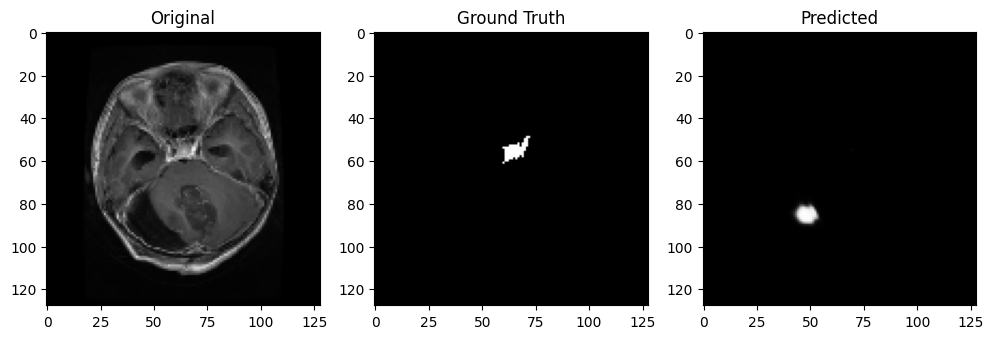

In [64]:
sample_images, sample_masks = val_gen[0]
pred_masks = model.predict(sample_images)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(sample_images[0])
plt.title("Original")

plt.subplot(1,3,2)
plt.imshow(sample_masks[0].squeeze(), cmap="gray")
plt.title("Ground Truth")

plt.subplot(1,3,3)
plt.imshow(pred_masks[0].squeeze(), cmap="gray")
plt.title("Predicted")

plt.show()


In [65]:
model.save("unet_brain_tumor_segmentation.h5")


In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from tensorflow.keras.models import load_model


In [2]:
model = load_model("unet_brain_tumor_segmentation.h5", compile=False)


In [8]:
input_root = r"F:\work\python\archive\classification_task"        # raw dataset
output_root = r"F:\work\python\archive\segmented_dataset"            # new dataset


In [16]:
IMG_SIZE = 128

In [17]:
def generate_mask(image):
    original_shape = image.shape[:2]

    #resize to model input size
    image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image_resized = image_resized / 255.0
    image_input = np.expand_dims(image_resized, axis=0)
    #Predict mask
    mask = model.predict(image_input, verbose=0)[0]

    #threshold
    mask = (mask > 0.5).astype(np.uint8)

    #resize mask back to original size
    mask = cv2.resize(mask, (original_shape[1], original_shape[0]))

    return mask

In [18]:
def apply_mask(original_img, mask):
    mask = np.expand_dims(mask, axis=-1)
    segmented = original_img * mask
    return segmented


In [19]:
for split in ["train", "test"]:

    split_path = os.path.join(input_root, split)

    for class_name in os.listdir(split_path):

        class_path = os.path.join(split_path, class_name)
        output_class_path = os.path.join(output_root, split, class_name)

        os.makedirs(output_class_path, exist_ok=True)

        print(f"\nProcessing {split} - {class_name}")

        for img_name in tqdm(os.listdir(class_path)):

            img_path = os.path.join(class_path, img_name)

            image = cv2.imread(img_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Generate mask
            mask = generate_mask(image_rgb)

            # Apply mask
            segmented_img = apply_mask(image, mask)

            # Save image
            save_path = os.path.join(output_class_path, img_name)
            cv2.imwrite(save_path, segmented_img)



Processing train - glioma


100%|██████████| 1147/1147 [02:05<00:00,  9.11it/s]



Processing train - meningioma


100%|██████████| 1329/1329 [02:21<00:00,  9.40it/s]



Processing train - no_tumor


100%|██████████| 1067/1067 [01:54<00:00,  9.33it/s]



Processing train - pituitary


100%|██████████| 1457/1457 [02:35<00:00,  9.38it/s]



Processing test - glioma


100%|██████████| 254/254 [00:27<00:00,  9.39it/s]



Processing test - meningioma


100%|██████████| 306/306 [00:33<00:00,  9.10it/s]



Processing test - no_tumor


100%|██████████| 140/140 [00:14<00:00,  9.60it/s]



Processing test - pituitary


100%|██████████| 300/300 [00:31<00:00,  9.46it/s]
